In [1]:
# Evaluate the ML model

import tensorflow as tf
from tensorflow import keras
import os
import glob
import numpy as np

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib as mpl
from utils import plot_loss, encoder_files_to_tensors, get_best_model_timestamp
from utils import load_model_data_new, unnormalize_params, assess_decoder
from utils import sample_files
from models import EncoderMulti

# data_dir = '/eos/user/k/kiliakis/tomo_data/datasets_encoder_02-12-22'
# data_dir = './tomo_data/datasets_encoder_02-12-22'
data_dir = './tomo_data/datasets_encoder_TF_16-12-22'

dataset_percent = 0.1
normalization = 'minmax'
num_Turns_Case = 1

var_names = ['phEr', 'enEr', 'bl',
             'inten', 
             'Vrf', 'mu', 'VrfSPS']


2022-12-19 09:56:26.314568: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 09:56:26.462852: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-19 09:56:26.466123: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/lib
2022-12-19 09:56:26.466141: I tensorflow/compiler/xla/st

In [2]:
# Initialize parameters
import time

# Initialize train/ test / validation paths
ML_dir = os.path.join(data_dir, 'ML_data')
TESTING_PATH = os.path.join(ML_dir, 'TESTING')
assert os.path.exists(TESTING_PATH)


# First the training data
file_names = sample_files(TESTING_PATH, dataset_percent, keep_every=num_Turns_Case)
print(len(file_names))
start_t = time.time()
# read input, divide in features/ label, create tensors
x_test, y_test = encoder_files_to_tensors(file_names, normalization=normalization)
total_time = time.time() - start_t
print(f'Elapsed time: {total_time:.3f}, Per file: {total_time/len(file_names):.3f}')


200


2022-12-19 09:56:28.362511: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/lib
2022-12-19 09:56:28.362528: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-19 09:56:28.362541: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sy153): /proc/driver/nvidia/version does not exist
2022-12-19 09:56:28.362757: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Elapsed time: 11.468, Per file: 0.057


In [3]:
# Model to load
# timestamp = get_best_model_timestamp('./trials', model='enc')
# timestamp = 'hybrid'
timestamp = '2022_12_18_11-48-57'
print(timestamp)

# Initialize directories
trial_dir = os.path.join('./trials/', timestamp)
weights_dir = os.path.join(trial_dir, 'weights')
plots_dir = os.path.join(trial_dir, 'plots')
assert os.path.exists(weights_dir)
os.makedirs(plots_dir, exist_ok=True)

encoder = EncoderMulti(weights_dir)
# models = [None]*len(var_names)
# for file in os.listdir(weights_dir):
#     if 'backup' in file:
#         continue
#     var_name = file.split('encoder_')[1].split('.h5')[0]
#     models[var_names.index(var_name)] = keras.models.load_model(os.path.join(weights_dir, file))



2022_12_18_11-48-57


In [6]:
test_pred = encoder.encode(x_test)
print(test_pred.shape)

(200, 7)


In [5]:
test_losses = {}
for var_name in var_names:
    model = encoder.model[var_names.index(var_name)]
    # if var_name == 'inten':
    #     continue
    idx = var_names.index(var_name)
    print(f'------ Evaluating {var_name} ------')
    test_loss = model.evaluate(x_test, tf.gather(y_test, idx, axis=1))
    # print(test_loss)
    if isinstance(test_loss, float):
        test_losses[var_name] = test_loss
    else:
        test_losses[var_name] = test_loss[0]

for name, mse in test_losses.items():
    print(f'{name}:\t{mse:.3e}')

print(f'\nMean loss: {np.mean([v for v in test_losses.values()]):.3e}')


------ Evaluating phEr ------
7/7 [==============================] - 0s 5ms/step - loss: 4.1552e-06 - mae: 0.0016
------ Evaluating enEr ------
7/7 [==============================] - 0s 4ms/step - loss: 1.8632e-05 - mae: 0.0033
------ Evaluating bl ------
7/7 [==============================] - 0s 4ms/step - loss: 1.6286e-04 - mae: 0.0103
------ Evaluating inten ------
7/7 [==============================] - 0s 5ms/step - loss: 0.0766 - mae: 0.2350
------ Evaluating Vrf ------
7/7 [==============================] - 0s 5ms/step - loss: 2.5516e-05 - mae: 0.0039
------ Evaluating mu ------
7/7 [==============================] - 0s 4ms/step - loss: 0.0011 - mae: 0.0236
------ Evaluating VrfSPS ------
7/7 [==============================] - 0s 3ms/step - loss: 0.0014 - mae: 0.0298
phEr:	4.155e-06
enEr:	1.863e-05
bl:	1.629e-04
inten:	7.655e-02
Vrf:	2.552e-05
mu:	1.146e-03
VrfSPS:	1.426e-03

Mean loss: 1.133e-02


In [ ]:
# test_pred = np.zeros(shape=(len(x_test), len(models)), dtype=float)
# for var_name, model in models.items():
#     idx = var_names.index(var_name)
#     print(f'------ Generating predictions for {var_name} ------')
#     test_pred[:, idx] = model.predict(x_test, verbose=False).reshape(-1)

# mses = mean_squared_error(y_test, test_pred, multioutput='raw_values')

# for name, mse in zip(var_names, mses):
#     print(f'{name}:\t{mse:.3e}')

# print(f'\nMean loss: {np.mean(mses):.3e}')


(200, 7)


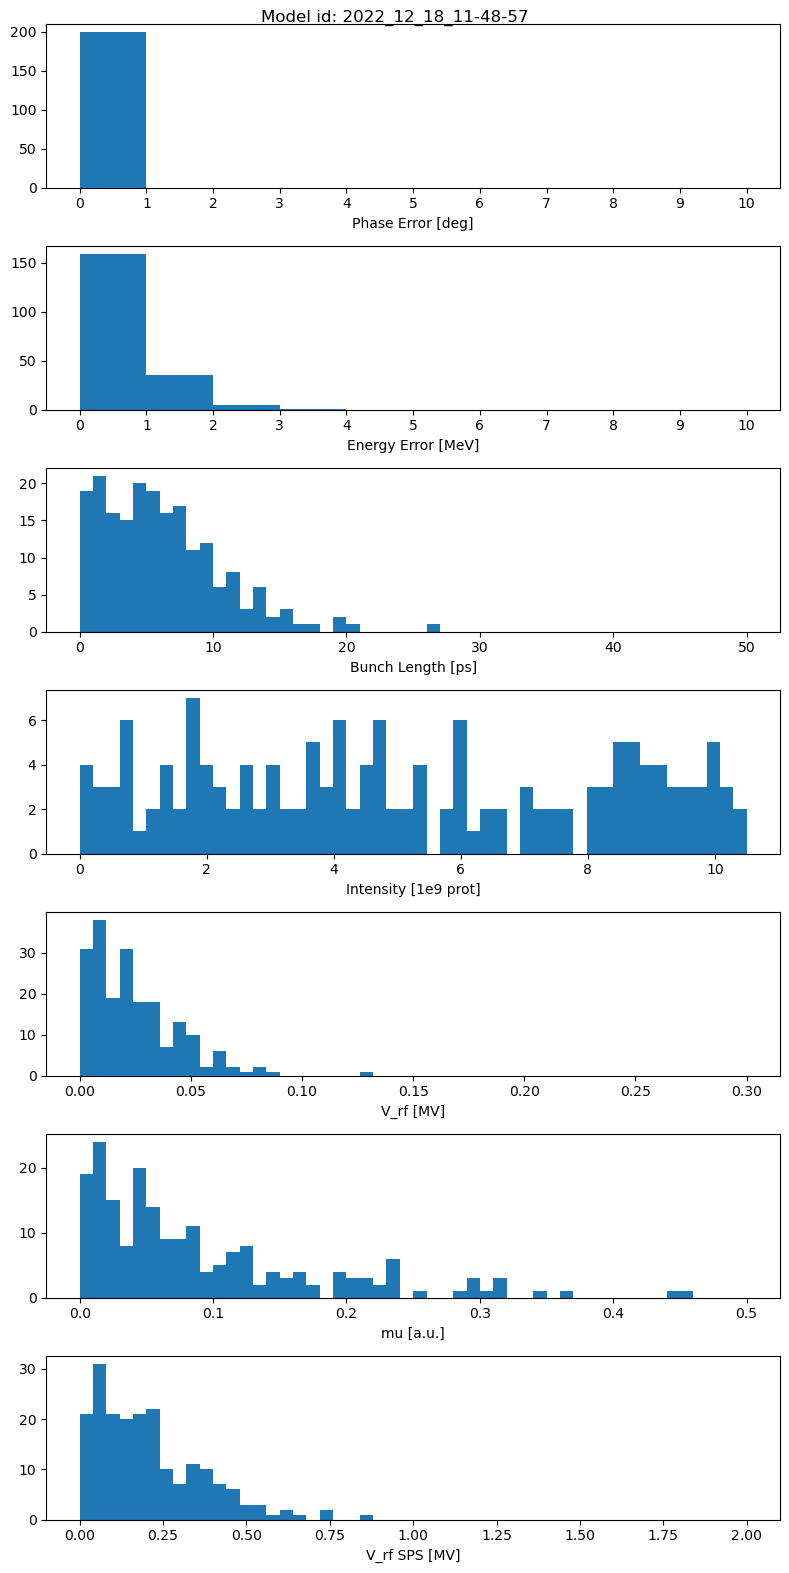

In [7]:

y_test_unnorm = unnormalize_params(
    y_test[:, 0], y_test[:, 1], y_test[:, 2],
    y_test[:, 3], y_test[:, 4], y_test[:, 5],
    y_test[:, 6], normalization=normalization)

y_pred_unnorm = unnormalize_params(
    test_pred[:, 0], test_pred[:, 1], test_pred[:, 2],
    test_pred[:, 3], test_pred[:, 4], test_pred[:, 5],
    test_pred[:, 6], normalization=normalization)

diffs = np.abs(np.array(y_pred_unnorm).T - np.array(y_test_unnorm).T)
print(diffs.shape)
fig, axes = plt.subplots(ncols=1, nrows=len(var_names), sharex=False,
                         sharey=False, figsize=(8, 16))
fig.suptitle(f'Model id: {timestamp}')

plt.sca(axes[0])
# plt.hist(diffs[:, 0], bins=100, range=(-50, 50))
plt.hist(diffs[:, 0], bins=10, range=(0, 10))
plt.xticks(np.arange(0, 10.5))
plt.xlabel('Phase Error [deg]')
plt.sca(axes[1])
plt.hist(diffs[:, 1], bins=10, range=(0, 10))
plt.xticks(np.arange(0, 10.5))
plt.xlabel('Energy Error [MeV]')
plt.sca(axes[2])
plt.hist(diffs[:, 2]*1e12, bins=50, range=(0, 50))
plt.xlabel('Bunch Length [ps]')
plt.sca(axes[3])
plt.hist(diffs[:, 3]*1e-10, bins=50, range=(0, 10.5))
plt.xlabel('Intensity [1e9 prot]')
plt.sca(axes[4])
plt.hist(diffs[:, 4], bins=50, range=(0, 0.3))
plt.xlabel('V_rf [MV]')
plt.sca(axes[5])
plt.hist(diffs[:, 5], bins=50, range=(0, 0.5))
plt.xlabel('mu [a.u.]')
plt.sca(axes[6])
plt.hist(diffs[:, 6], bins=50, range=(0, 2))
plt.xlabel('V_rf SPS [MV]')
plt.tight_layout()
# plt.savefig('plots/enc-evaluation-hybrid.jpg', dpi=400)



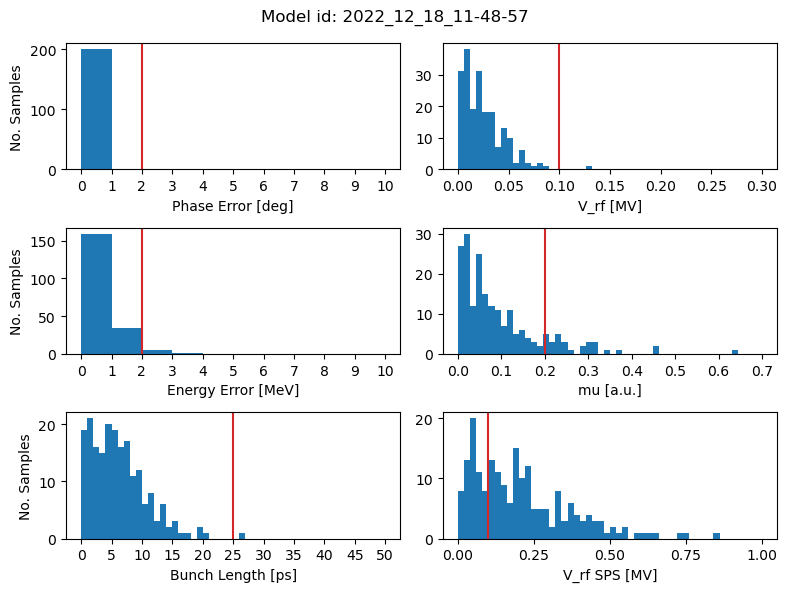

In [10]:
fig, axes = plt.subplots(ncols=2, nrows=3, sharex=False,
                         sharey=False, figsize=(8, 6))
fig.suptitle(f'Model id: {timestamp}')

plt.sca(axes[0][0])
plt.hist(diffs[:, 0], bins=10, range=(0, 10))
plt.xticks(np.arange(0, 10.5))
plt.xlabel('Phase Error [deg]')
plt.ylabel('No. Samples')
plt.axvline(x=2, color='tab:red')

plt.sca(axes[1][0])
plt.hist(diffs[:, 1], bins=10, range=(0, 10))
plt.xticks(np.arange(0, 10.5))
plt.xlabel('Energy Error [MeV]')
plt.ylabel('No. Samples')
plt.axvline(x=2, color='tab:red')

plt.sca(axes[2][0])
plt.hist(diffs[:, 2]*1e12, bins=50, range=(0, 50))
plt.xticks(np.arange(0, 50.5, 5))
plt.xlabel('Bunch Length [ps]')
plt.ylabel('No. Samples')
plt.axvline(x=25, color='tab:red')

plt.sca(axes[0][1])
plt.hist(diffs[:, 4], bins=50, range=(0, 0.3))
plt.xlabel('V_rf [MV]')
plt.axvline(x=0.1, color='tab:red')

plt.sca(axes[1][1])
plt.hist(diffs[:, 5], bins=50, range=(0, 0.7))
plt.xticks(np.arange(0, 0.71, 0.1))
plt.xlabel('mu [a.u.]')
plt.axvline(x=0.2, color='tab:red')

plt.sca(axes[2][1])
plt.hist(diffs[:, 6], bins=50, range=(0, 1))
plt.xticks(np.arange(0, 1.1, 0.25))
plt.xlabel('V_rf SPS [MV]')
plt.axvline(x=0.1, color='tab:red')

plt.tight_layout()
plt.savefig(f'plots/enc-evaluation-{timestamp}.jpg', dpi=400)


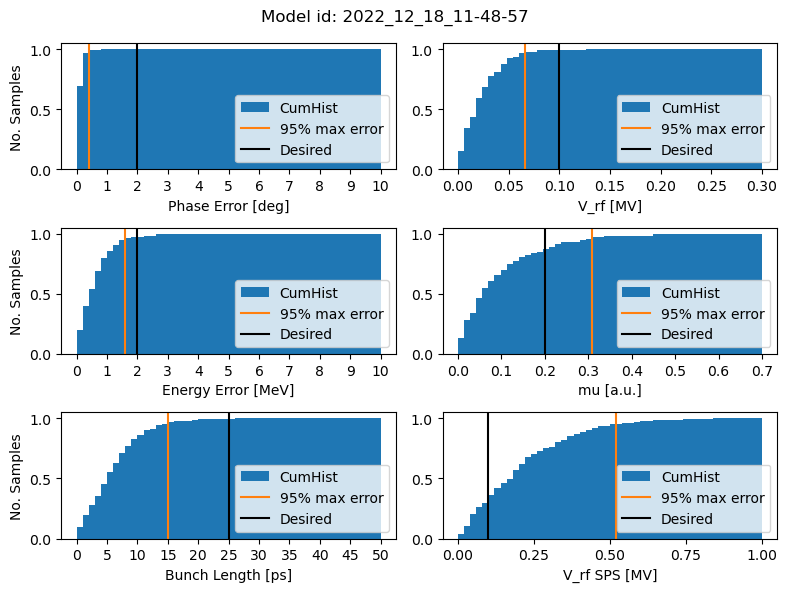

In [11]:
import bisect

fig, axes = plt.subplots(ncols=2, nrows=3, sharex=False,
                         sharey=False, figsize=(8, 6))
fig.suptitle(f'Model id: {timestamp}')

plt.sca(axes[0][0])
n, bins, patches = plt.hist(diffs[:, 0], bins=50, range=(0, 10),
                            cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xticks(np.arange(0, 10.5))
plt.xlabel('Phase Error [deg]')
plt.ylabel('No. Samples')
plt.axvline(x=2, color='black', label='Desired')
plt.legend(loc='lower right')

plt.sca(axes[1][0])
n, bins, patches = plt.hist(diffs[:, 1], bins=50, range=(0, 10),
                            cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xticks(np.arange(0, 10.5))
plt.xlabel('Energy Error [MeV]')
plt.ylabel('No. Samples')
plt.axvline(x=2, color='black', label='Desired')
plt.legend(loc='lower right')

plt.sca(axes[2][0])
n, bins, patches = plt.hist(
    diffs[:, 2]*1e12, bins=50, range=(0, 50),
    cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xticks(np.arange(0, 50.5, 5))
plt.xlabel('Bunch Length [ps]')
plt.ylabel('No. Samples')
plt.axvline(x=25, color='black', label='Desired')
plt.legend(loc='lower right')

plt.sca(axes[0][1])
n, bins, patches = plt.hist(diffs[:, 4], bins=50, range=(0, 0.3),
                            cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xlabel('V_rf [MV]')
plt.axvline(x=0.1, color='black', label='Desired')
plt.legend(loc='lower right')

plt.sca(axes[1][1])
n, bins, patches = plt.hist(diffs[:, 5], bins=50, range=(0, 0.7),
                            cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xticks(np.arange(0, 0.71, 0.1))
plt.xlabel('mu [a.u.]')
plt.axvline(x=0.2, color='black', label='Desired')
plt.legend(loc='lower right')

plt.sca(axes[2][1])
n, bins, patches = plt.hist(diffs[:, 6], bins=50, range=(0, 1),
                            cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xticks(np.arange(0, 1.1, 0.25))
plt.xlabel('V_rf SPS [MV]')
plt.axvline(x=0.1, color='black', label='Desired')
plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig(f'plots/enc-cumulative-hist-{timestamp}.jpg', dpi=400)


In [ ]:
# Also generate MSE histogram
# print(valid_pred.shape)
# square_errors = ((y_test - test_pred) * (y_test - test_pred))

# fig, axes = plt.subplots(ncols=1, nrows=len(var_names), sharex=False,
# sharey=True, figsize=(8, 16))
# for i, name in enumerate(var_names):
#     hist,edges = np.histogram(square_errors[:, i], bins=10, density=False)
#     hist = hist / len(square_errors[:, i])
#     print(name, hist)
#     ax = axes[i]
#     plt.sca(ax)
#     plt.bar(np.arange(len(hist)), hist, width=0.8)
#     plt.title(name)
#     edges = [f'{e:.4f}' for e in edges]
#     plt.xticks(np.arange(len(hist)), edges[1:])
#     plt.xlabel('Error')
#     plt.ylabel('Density')
#     plt.tight_layout()
